In [1]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
from IPython.display import Audio
import librosa.display

In [2]:
data_dir = '../data/preprocessing/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)
print(labels_df_path)

labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

print(labels_df)



random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
y

../data/preprocessing/df_iemocap.csv
       start_time  end_time             wav_file emotion  val  act  dom
0            6.77    8.4600  Ses01M_impro01_F000     ang  1.5  3.5  4.5
1            8.55   10.6000  Ses01M_impro01_F001     ang  2.5  3.5  3.5
2           14.46   18.2300  Ses01M_impro01_F002     xxx  3.0  3.0  3.5
3           19.48   23.4300  Ses01M_impro01_F003     xxx  3.0  3.0  3.0
4           23.43   26.4675  Ses01M_impro01_F004     fru  2.5  3.5  3.5
...           ...       ...                  ...     ...  ...  ...  ...
10034      252.71  255.5000  Ses05M_impro04_M037     fru  2.5  3.0  3.0
10035      262.01  264.0000  Ses05M_impro04_M038     fru  3.0  3.0  3.5
10036      264.79  266.3100  Ses05M_impro04_M039     fru  2.5  3.0  3.5
10037      267.83  270.4200  Ses05M_impro04_M040     ang  3.0  3.0  3.5
10038      273.80  275.8900  Ses05M_impro04_M041     sad  2.0  2.5  3.5

[10039 rows x 7 columns]


array([ 0.0005183 ,  0.00012719, -0.0002677 , ...,  0.00291492,
        0.00278763,  0.00277061], dtype=float32)

In [5]:
labels_df['new_emotion'] = labels_df['emotion'].apply(lambda x: x if x in ['ang','fru'] else 'others')
labels_df['time_gap'] = labels_df['end_time']-labels_df['start_time'] 

In [ ]:
labels_df

df = pd.read_csv('../data/preprocessing/audio_features_wiz_mcc.csv')

df.groupby('label').count()


In [202]:
labels_df[['wav_file','time_gap']].merge(df,on='wav_file').to_csv('../data/preprocessing/audio_features_full.csv')

In [6]:
sampled_wav_file_list = labels_df.groupby('new_emotion').sample(n=3, random_state=42)['wav_file'].tolist()
sampled_emotion_list = labels_df.groupby('new_emotion').sample(n=3, random_state=42)['new_emotion'].tolist()


In [8]:
file_dict = {'Ses02': '../data/preprocessing/audio_vectors_2.pkl',
             'Ses03': '../data/preprocessing/audio_vectors_3.pkl',
             'Ses04': '../data/preprocessing/audio_vectors_4.pkl',
             'Ses05': '../data/preprocessing/audio_vectors_5.pkl',
             'Ses01': '../data/preprocessing/audio_vectors_1.pkl'}

def get_data_pkl_file(wav_file):
    file_key = wav_file[0:5]
    file_path = file_dict[file_key]
    return file_path

def get_audio_vector(wav_file):
    file_path = get_data_pkl_file(wav_file)
    audio_vectors = pickle.load(open(file_path, 'rb'))
    return audio_vectors[wav_file]
    

In [69]:
audiocode2text = pickle.load(open('../data/model_file/audiocode2text.pkl', 'rb'))
# Convert the dictionary to a DataFrame
df_audiocode2text = pd.DataFrame(list(audiocode2text.items()), columns=['wav_file', 'Text'])
df = labels_df.merge(df_audiocode2text,on='wav_file')


In [70]:
# Extract text features
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))
df['char_count'] = df['Text'].apply(lambda x: len(x))
df['avg_word_length'] = df['Text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

# Display the first few rows with new features
df.head()


start_time  end_time             wav_file emotion  val  act  dom  \
0        6.77    8.4600  Ses01M_impro01_F000     ang  1.5  3.5  4.5   
1        8.55   10.6000  Ses01M_impro01_F001     ang  2.5  3.5  3.5   
2       14.46   18.2300  Ses01M_impro01_F002     xxx  3.0  3.0  3.5   
3       19.48   23.4300  Ses01M_impro01_F003     xxx  3.0  3.0  3.0   
4       23.43   26.4675  Ses01M_impro01_F004     fru  2.5  3.5  3.5   

  new_emotion  time_gap                                               Text  \
0         ang    1.6900                                              Next.   
1         ang    2.0500                                 My window is open.   
2      others    3.7700    This is... Your last- Your first name is Jones?   
3      others    3.9500  That's just strange I figured you filled in wr...   
4         fru    3.0375  What are you... what's...What are you applying...   

   word_count  char_count  avg_word_length  
0           1           5         5.000000  
1           4          18         3.750000  
2           9          47         4.333333  
3          10          59         5.000000  
4           8          51         5.500000

In [71]:
# Group by new_emotion and calculate mean text features
text_features = df.groupby('new_emotion').agg({
    'word_count': 'mean',
    'char_count': 'mean',
    'avg_word_length': 'mean'
}).reset_index()

# Display the text features by new_emotion
text_features


new_emotion  word_count  char_count  avg_word_length
0         ang   12.640979   64.183137         4.233440
1         fru   13.441860   67.488372         4.273268
2      others   10.909976   55.468463         4.333330

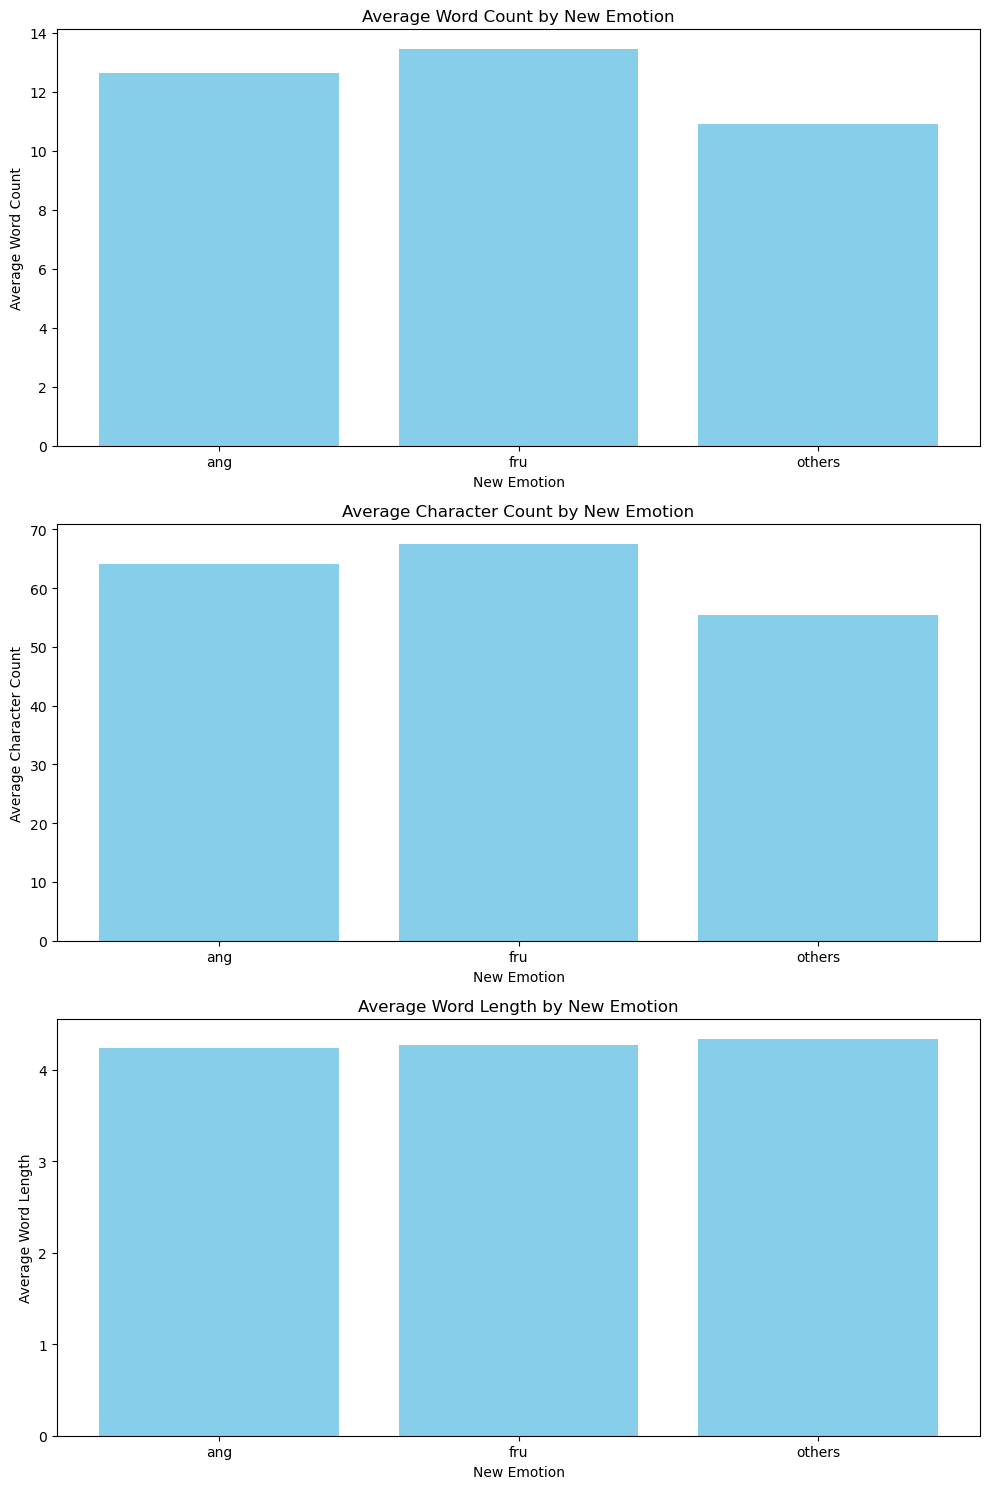

In [72]:
# Plot text features by new_emotion
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Word count
axes[0].bar(text_features['new_emotion'], text_features['word_count'], color='skyblue')
axes[0].set_xlabel('New Emotion')
axes[0].set_ylabel('Average Word Count')
axes[0].set_title('Average Word Count by New Emotion')

# Character count
axes[1].bar(text_features['new_emotion'], text_features['char_count'], color='skyblue')
axes[1].set_xlabel('New Emotion')
axes[1].set_ylabel('Average Character Count')
axes[1].set_title('Average Character Count by New Emotion')

# Average word length
axes[2].bar(text_features['new_emotion'], text_features['avg_word_length'], color='skyblue')
axes[2].set_xlabel('New Emotion')
axes[2].set_ylabel('Average Word Length')
axes[2].set_title('Average Word Length by New Emotion')

plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 kB 897.0 kB/s eta 0:00:00a 0:00:01


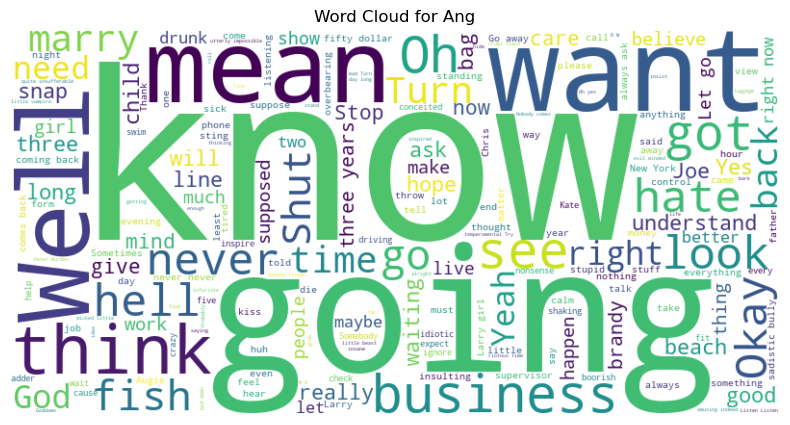

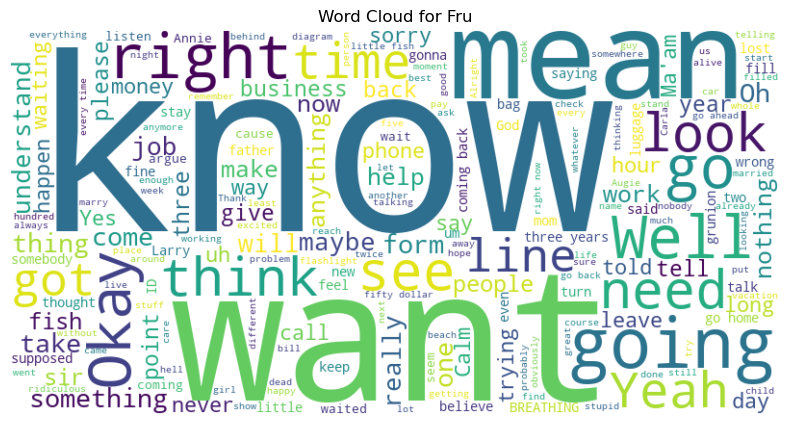

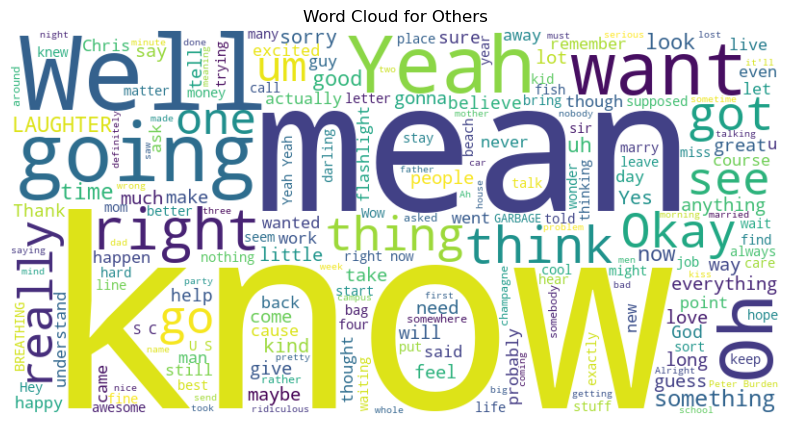

In [74]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine text data for each emotion category
text_by_emotion = df.groupby('new_emotion')['Text'].apply(lambda texts: ' '.join(texts)).reset_index()

# Function to generate and plot a word cloud
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate and plot word clouds for each emotion category
for index, row in text_by_emotion.iterrows():
    plot_word_cloud(row['Text'], f"Word Cloud for {row['new_emotion'].capitalize()}")


In [79]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess text (tokenize, remove stopwords)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Apply preprocessing
df['tokens'] = df['Text'].apply(preprocess_text)
df.head()


[nltk_data] Downloading package punkt to /Users/sensenc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sensenc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


start_time  end_time             wav_file emotion  val  act  dom  \
0        6.77    8.4600  Ses01M_impro01_F000     ang  1.5  3.5  4.5   
1        8.55   10.6000  Ses01M_impro01_F001     ang  2.5  3.5  3.5   
2       14.46   18.2300  Ses01M_impro01_F002     xxx  3.0  3.0  3.5   
3       19.48   23.4300  Ses01M_impro01_F003     xxx  3.0  3.0  3.0   
4       23.43   26.4675  Ses01M_impro01_F004     fru  2.5  3.5  3.5   

  new_emotion  time_gap                                               Text  \
0         ang    1.6900                                              Next.   
1         ang    2.0500                                 My window is open.   
2      others    3.7700    This is... Your last- Your first name is Jones?   
3      others    3.9500  That's just strange I figured you filled in wr...   
4         fru    3.0375  What are you... what's...What are you applying...   

   word_count  char_count  avg_word_length  \
0           1           5         5.000000   
1           4          18         3.750000   
2           9          47         4.333333   
3          10          59         5.000000   
4           8          51         5.500000   

                                        tokens  
0                                       [next]  
1                               [window, open]  
2                         [first, name, jones]  
3  [strange, figured, filled, wrong, sections]  
4                                   [applying]

In [82]:
from collections import defaultdict

# Combine text data for each emotion category
text_by_emotion = defaultdict(list)
for index, row in df.iterrows():
    text_by_emotion[row['new_emotion']].extend(row['tokens'])

# Function to get word frequencies
def get_word_frequencies(tokens):
    return Counter(tokens)

# Calculate word frequencies for each emotion
word_freqs = {emotion: get_word_frequencies(tokens) for emotion, tokens in text_by_emotion.items()}

# Display word frequencies
for emotion, freq in word_freqs.items():
    print(f"Word Frequencies for {emotion}:")
    print(freq.most_common(10))


Word Frequencies for ang:
[('like', 121), ('know', 96), ('going', 85), ('want', 79), ('go', 73), ('never', 68), ('get', 61), ('oh', 59), ('mean', 58), ('think', 55)]
Word Frequencies for others:
[('know', 1246), ('like', 859), ('well', 566), ('yeah', 558), ('mean', 500), ('going', 477), ('right', 451), ('oh', 442), ('want', 387), ('get', 322)]
Word Frequencies for fru:
[('know', 362), ('like', 204), ('want', 191), ('get', 166), ('go', 165), ('mean', 157), ('going', 145), ('ca', 142), ('right', 124), ('well', 105)]


In [83]:
# Combine tokens back to text for TF-IDF analysis
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Create a DataFrame with TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_scores, columns=feature_names)
tfidf_df['new_emotion'] = df['new_emotion']

# Display top TF-IDF scores for each emotion
for emotion in tfidf_df['new_emotion'].unique():
    emotion_tfidf = tfidf_df[tfidf_df['new_emotion'] == emotion].drop(columns=['new_emotion'])
    top_tfidf = emotion_tfidf.mean().sort_values(ascending=False).head(10)
    print(f"Top TF-IDF scores for {emotion}:")
    print(top_tfidf)


Top TF-IDF scores for ang:
like        0.025260
going       0.023335
business    0.021817
hell        0.021551
turn        0.019921
oh          0.018808
want        0.018537
yes         0.017243
go          0.016761
shut        0.016010
dtype: float64
Top TF-IDF scores for others:
know     0.044005
yeah     0.038710
well     0.025576
like     0.025444
oh       0.022434
right    0.021086
going    0.019316
mean     0.017593
okay     0.016750
want     0.015544
dtype: float64
Top TF-IDF scores for fru:
know     0.041369
want     0.031281
go       0.024529
ca       0.024474
right    0.022964
get      0.021577
like     0.020534
going    0.019123
okay     0.018411
mean     0.018358
dtype: float64


In [29]:
INT = 0
print(sampled_emotion_list[INT])
y1 = get_audio_vector(sampled_wav_file_list[INT])#sampled_emotion_list[0]

INT_ = INT+3
print(sampled_emotion_list[INT_])
y2 = get_audio_vector(sampled_wav_file_list[INT_])

INT__ = INT+6
print(sampled_emotion_list[INT__])
y3 = get_audio_vector(sampled_wav_file_list[INT__])

# min_len = min(len(y1), len(y2),len(y3))
# y1, y2,y3 = y1[:min_len], y2[:min_len],y3[:min_len]

ang
fru
others


/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_43631/722205836.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


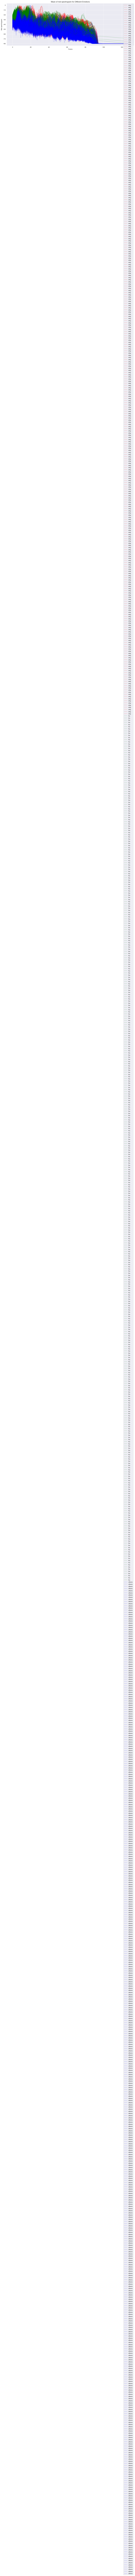

In [30]:
plt.show()
y1_harmonic = librosa.power_to_db(librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128), ref=np.max)
y2_harmonic = librosa.power_to_db(librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=128), ref=np.max)
y3_harmonic = librosa.power_to_db(librosa.feature.melspectrogram(y=y3, sr=sr, n_mels=128), ref=np.max)

# Plot the harmonic components
plt.figure(figsize=(15, 5))
plt.plot(y1_harmonic, color='r', label=sampled_emotion_list[INT],alpha=0.25)
plt.plot(y2_harmonic, color='g', label=sampled_emotion_list[INT_],alpha=0.25)
plt.plot(y3_harmonic, color='b', label=sampled_emotion_list[INT__],alpha=0.25)

# Adding labels and legend
plt.xlabel('Frame')
plt.ylabel('Mel spectrogram')
plt.title('Mean of mel spectrogram for Different Emotions')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

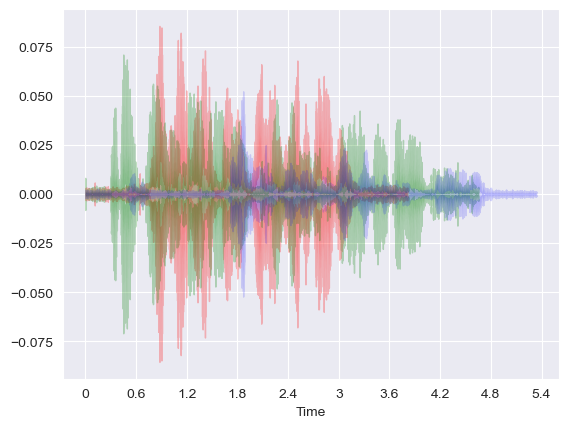

In [11]:
sr = 44100

fig, (ax) = plt.subplots(nrows=1, sharex=True)

librosa.display.waveshow(y1, sr=sr, alpha=0.25, color='r',label=sampled_emotion_list[INT])
librosa.display.waveshow(y2, sr=sr, alpha=0.25, color='g',label=sampled_emotion_list[INT_])
librosa.display.waveshow(y3, sr=sr, alpha=0.15, color='b',label=sampled_emotion_list[INT__])

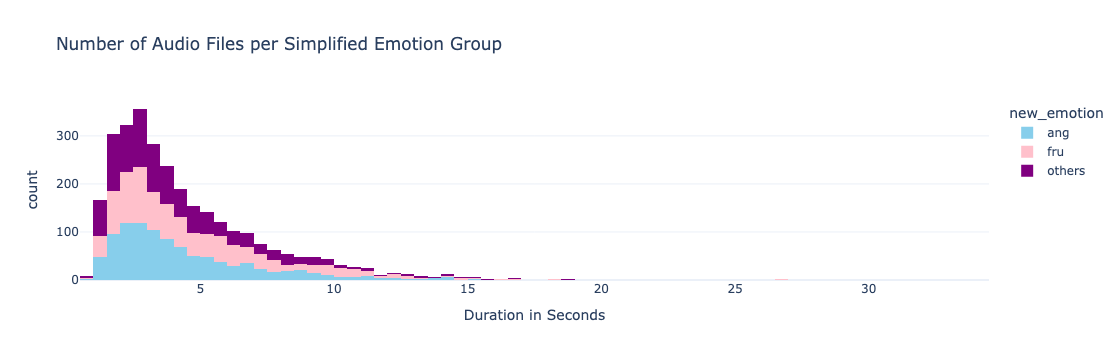

In [119]:
import plotly.express as px

labels_df_updated = labels_df.groupby('new_emotion').sample(n=1000, random_state=42)

template = 'plotly_white'
labels_df_new = labels_df[labels_df.new_emotion == 'ang']
fig = px.histogram(labels_df_updated, x='time_gap', 
             labels= {'time_gap': 'Duration in Seconds'},
             title='Number of Audio Files per Simplified Emotion Group',color='new_emotion',template=template,color_discrete_sequence=['skyblue','pink','purple'])

fig.update_layout(showlegend=True)
fig.show()

In [115]:
labels_df_updated.groupby('new_emotion').count()

start_time  end_time  wav_file  emotion   val   act   dom  \
new_emotion                                                              
ang                1000      1000      1000     1000  1000  1000  1000   
fru                1000      1000      1000     1000  1000  1000  1000   
others             1000      1000      1000     1000  1000  1000  1000   

             time_gap  
new_emotion            
ang              1000  
fru              1000  
others           1000

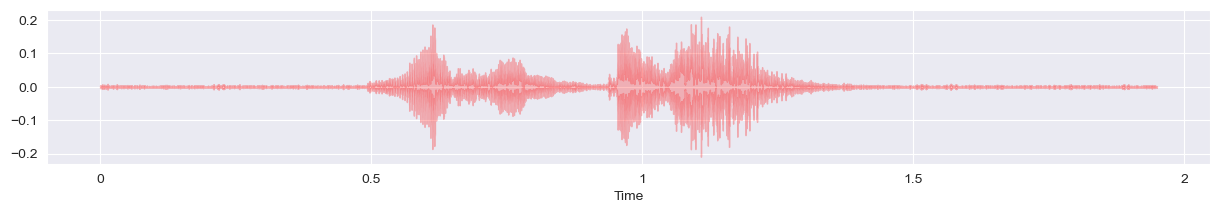

In [12]:
data_dir = '../data/preprocessing/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

random_file_name

plt.figure(figsize=(15,2))
librosa.display.waveshow(y, sr=sr, alpha=0.25, color='r')

In [59]:

y1 = audio_vectors['Ses01M_impro01_F001']
sr = 44100

y2 = audio_vectors['Ses01M_impro01_F002']
sr = 44100

In [58]:
audio_vectors.keys()

dict_keys(['Ses01M_impro02_F000', 'Ses01M_impro02_F001', 'Ses01M_impro02_F002', 'Ses01M_impro02_F003', 'Ses01M_impro02_F004', 'Ses01M_impro02_F005', 'Ses01M_impro02_F006', 'Ses01M_impro02_F007', 'Ses01M_impro02_F008', 'Ses01M_impro02_F009', 'Ses01M_impro02_F010', 'Ses01M_impro02_F011', 'Ses01M_impro02_F012', 'Ses01M_impro02_F013', 'Ses01M_impro02_F014', 'Ses01M_impro02_F015', 'Ses01M_impro02_F016', 'Ses01M_impro02_F017', 'Ses01M_impro02_F018', 'Ses01M_impro02_F019', 'Ses01M_impro02_F020', 'Ses01M_impro02_F021', 'Ses01M_impro02_M000', 'Ses01M_impro02_M001', 'Ses01M_impro02_M002', 'Ses01M_impro02_M003', 'Ses01M_impro02_M004', 'Ses01M_impro02_M005', 'Ses01M_impro02_M006', 'Ses01M_impro02_M007', 'Ses01M_impro02_M008', 'Ses01M_impro02_M009', 'Ses01M_impro02_M010', 'Ses01M_impro02_M011', 'Ses01M_impro02_M012', 'Ses01M_impro02_M013', 'Ses01M_impro02_M014', 'Ses01M_impro02_M015', 'Ses01M_impro02_M016', 'Ses01M_impro02_M017', 'Ses01M_impro02_M018', 'Ses01M_impro02_M019', 'Ses01M_impro02_M020', 

In [63]:
Audio(y2, rate=sr)


In [2]:
audio_vectors = pickle.load(open('../data/preprocessing/audio_vectors_1.pkl', 'rb'))

In [57]:
df = pd.read_csv('/Users/sensenc/PycharmProjects/sound_detection_project/third_listener/data/preprocessing/audio_features.csv')

df

wav_file  label  sig_mean   sig_std  rmse_mean  rmse_std  \
0      Ses01M_impro01_F000      0  0.031214  0.084176   0.038141  0.074893   
1      Ses01M_impro01_F001      0  0.028566  0.046963   0.035969  0.030096   
2      Ses01M_impro01_F002      8  0.033234  0.052774   0.041894  0.032028   
3      Ses01M_impro01_F003      8  0.010153  0.017512   0.013108  0.011582   
4      Ses01M_impro01_F004      4  0.017333  0.034097   0.022023  0.025986   
...                    ...    ...       ...       ...        ...       ...   
10026  Ses05M_impro04_M037      4  0.004781  0.007676   0.006008  0.004754   
10027  Ses05M_impro04_M038      4  0.006959  0.011449   0.008881  0.007185   
10028  Ses05M_impro04_M039      4  0.002753  0.004927   0.003436  0.003526   
10029  Ses05M_impro04_M040      0  0.004939  0.010740   0.006156  0.008774   
10030  Ses05M_impro04_M041      3  0.002048  0.003644   0.002610  0.002528   

        silence  harmonic  auto_corr_max  auto_corr_std  
0      0.678082 -0.332767       0.116155       0.671631  
1      0.288136 -0.000076       0.111075       0.435513  
2      0.233846 -0.007964       0.153142       0.968493  
3      0.384164 -0.019876       0.013832       0.103198  
4      0.404580 -0.005311       0.039119       0.236239  
...         ...       ...            ...            ...  
10026  0.261411 -0.003041       0.003118       0.019097  
10027  0.180233 -0.000086       0.006576       0.028932  
10028  0.076336 -0.005255       0.000985       0.004158  
10029  0.687500 -0.012045       0.002941       0.024937  
10030  0.000000 -0.008229       0.000566       0.004154  

[10031 rows x 10 columns]

In [84]:
df.groupby('label').count()

wav_file  sig_mean  sig_std  rmse_mean  rmse_std  silence  harmonic  \
label                                                                        
0          1101      1101     1101       1101      1101     1101      1101   
1           595       595      595        595       595      595       595   
2          1041      1041     1041       1041      1041     1041      1041   
3          1084      1084     1084       1084      1084     1084      1084   
4          1847      1847     1847       1847      1847     1847      1847   
5            40        40       40         40        40       40        40   
6           107       107      107        107       107      107       107   
7          1708      1708     1708       1708      1708     1708      1708   
8          2508      2508     2508       2508      2508     2508      2508   

       auto_corr_max  auto_corr_std  
label                                
0               1101           1101  
1                595            595  
2               1041           1041  
3               1084           1084  
4               1847           1847  
5                 40             40  
6                107            107  
7               1708           1708  
8               2508           2508

In [23]:
audio_vectors

{'Ses01M_impro02_F000': array([0.00124347, 0.0010768 , 0.00083568, ..., 0.00565154, 0.00574197,
        0.00604314], dtype=float32),
 'Ses01M_impro02_F001': array([0.0004122 , 0.00040062, 0.00035831, ..., 0.00217022, 0.00236324,
        0.00245607], dtype=float32),
 'Ses01M_impro02_F002': array([-0.00037797, -0.00039225, -0.00030147, ...,  0.00067835,
         0.00089048,  0.00102163], dtype=float32),
 'Ses01M_impro02_F003': array([ 0.00128433,  0.00116735,  0.00104925, ..., -0.00043751,
        -0.00029796, -0.0001061 ], dtype=float32),
 'Ses01M_impro02_F004': array([ 0.00737098,  0.00787716,  0.00835199, ..., -0.00313334,
        -0.00329856, -0.00341014], dtype=float32),
 'Ses01M_impro02_F005': array([ 0.00106975,  0.00086608,  0.00073763, ..., -0.00227357,
        -0.00243385, -0.00254518], dtype=float32),
 'Ses01M_impro02_F006': array([ 0.00742832,  0.00552066,  0.00373073, ..., -0.01164564,
        -0.01240683, -0.01322537], dtype=float32),
 'Ses01M_impro02_F007': array([-0.00427

In [3]:
y1 = audio_vectors['Ses01F_script01_2_F011']  # Angry
y2 = audio_vectors['Ses01F_script02_2_F036']  # Sad

In [25]:
y1

array([ 2.5484101e-03,  2.5336524e-03,  2.4650327e-03, ...,
       -1.9335239e-04, -8.3084618e-05,  5.8608366e-05], dtype=float32)

In [4]:
min_len = min(len(y1), len(y2))
y1, y2 = y1[:min_len], y2[:min_len]

In [5]:
sr = 44100

In [71]:
Audio(y1, rate=sr)

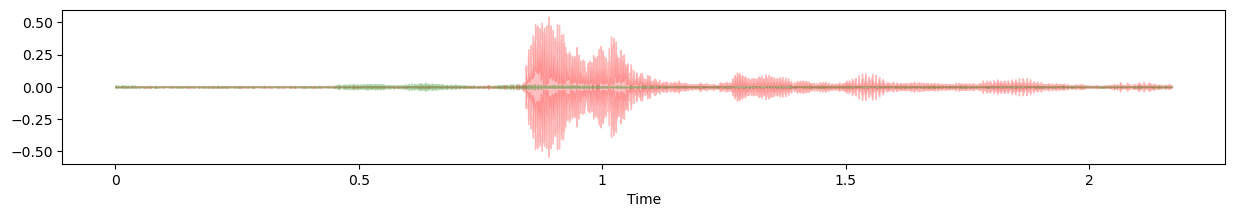

In [10]:
plt.figure(figsize=(15,2))
librosa.display.waveshow(y1, sr=sr, alpha=0.25, color='r')
librosa.display.waveshow(y2, sr=sr,alpha=0.25, color='g')

/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_79010/2342900725.py:1: FutureWarning: Pass y=[-0.00012865 -0.00011245 -0.00010499 ...  0.0018613   0.00175809
  0.00165778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse1 = librosa.feature.rms(y1 + 0.0001)[0]
/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_79010/2342900725.py:2: FutureWarning: Pass y=[ 0.00624308  0.00647873  0.00716308 ... -0.0026593  -0.00264615
 -0.00262061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse2 = librosa.feature.rms(y2 + 0.0001)[0]
/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_79010/2342900725.py:3: FutureWarning: Pass y=[-0.00139187 -0.00132403 -0.00118372 ...  0.00097506  0.00099386
  0.0010248 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse3 = librosa.feature.rms(y3 + 0.0001)[0]


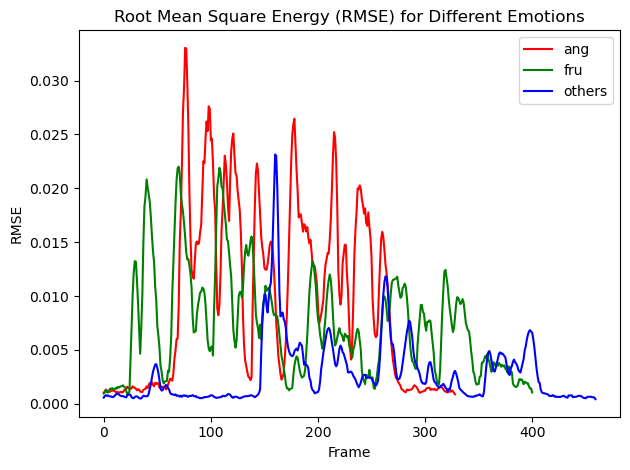

In [32]:
rmse1 = librosa.feature.rms(y1 + 0.0001)[0]
rmse2 = librosa.feature.rms(y2 + 0.0001)[0]
rmse3 = librosa.feature.rms(y3 + 0.0001)[0]

# plt.figure(figsize=(15,2))
plt.plot(rmse1, color='r',label =sampled_emotion_list[INT])
plt.plot(rmse2, color='g',label=sampled_emotion_list[INT_])
plt.plot(rmse3, color='b',label=sampled_emotion_list[INT__])

plt.ylabel('RMSE')

# Adding labels and legend
plt.xlabel('Frame')
plt.ylabel('RMSE')
plt.title('Root Mean Square Energy (RMSE) for Different Emotions')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_43631/1621116566.py:1: FutureWarning: Pass y=[-0.00012865 -0.00011245 -0.00010499 ...  0.0018613   0.00175809
  0.00165778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse1 = librosa.feature.rms(y1 + 0.0001)[0]
/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_43631/1621116566.py:2: FutureWarning: Pass y=[ 0.00624308  0.00647873  0.00716308 ... -0.0026593  -0.00264615
 -0.00262061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse2 = librosa.feature.rms(y2 + 0.0001)[0]
/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_43631/1621116566.py:3: FutureWarning: Pass y=[-0.00139187 -0.00132403 -0.00118372 ...  0.00097506  0.00099386
  0.0010248 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse3 = librosa.feature.rms(y3 + 0.0001)[0]


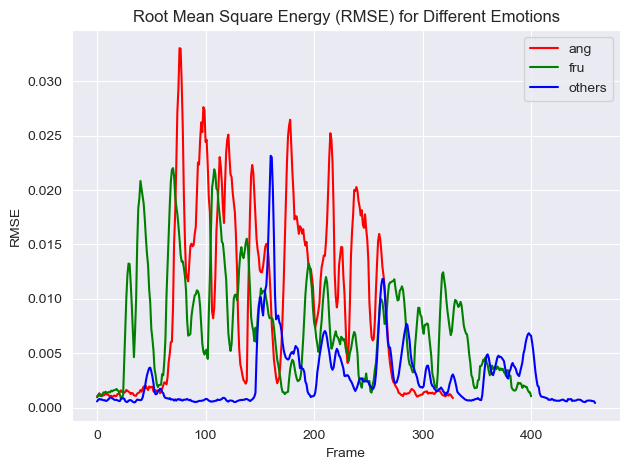

In [13]:
rmse1 = librosa.feature.rms(y1 + 0.0001)[0]
rmse2 = librosa.feature.rms(y2 + 0.0001)[0]
rmse3 = librosa.feature.rms(y3 + 0.0001)[0]

# plt.figure(figsize=(15,2))
plt.plot(rmse1, color='r',label =sampled_emotion_list[INT])
plt.plot(rmse2, color='g',label=sampled_emotion_list[INT_])
plt.plot(rmse3, color='b',label=sampled_emotion_list[INT__])

plt.ylabel('RMSE')

# Adding labels and legend
plt.xlabel('Frame')
plt.ylabel('RMSE')
plt.title('Root Mean Square Energy (RMSE) for Different Emotions')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [84]:
silence1 = 0
for e in rmse1:
    if e <= 0.3 * np.mean(rmse1):
        silence1 += 1
        
silence2 = 0
for e in rmse2:
    if e <= 0.3 * np.mean(rmse2):
        silence2 += 1

print(silence1/float(len(rmse1)), silence2/float(len(rmse2)))

0.3981762917933131 0.16209476309226933


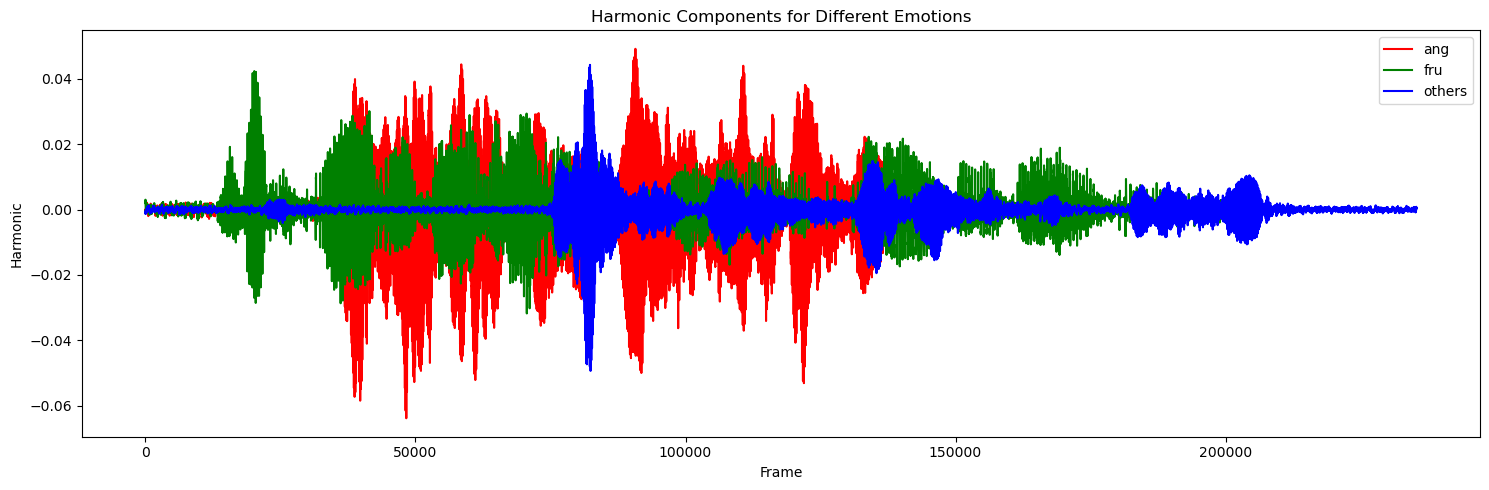

In [85]:

y1_harmonic = librosa.effects.hpss(y1)[0]
y2_harmonic = librosa.effects.hpss(y2)[0]
y3_harmonic = librosa.effects.hpss(y3)[0]

# Plot the harmonic components
plt.figure(figsize=(15, 5))
plt.plot(y1_harmonic, color='r', label=sampled_emotion_list[INT])
plt.plot(y2_harmonic, color='g', label=sampled_emotion_list[INT_])
plt.plot(y3_harmonic, color='b', label=sampled_emotion_list[INT__])

# Adding labels and legend
plt.xlabel('Frame')
plt.ylabel('Harmonic')
plt.title('Harmonic Components for Different Emotions')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

/var/folders/2z/9zfdwvxd34j7l53zzdmt6pl80000gn/T/ipykernel_43631/1380166313.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


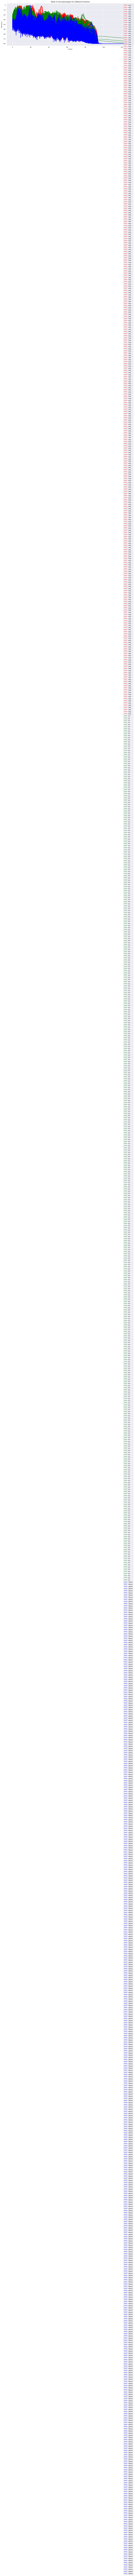

In [19]:
y1_harmonic = librosa.power_to_db(librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128),ref=np.max)
y2_harmonic = librosa.power_to_db(librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=128),ref=np.max)
y3_harmonic = librosa.power_to_db(librosa.feature.melspectrogram(y=y3, sr=sr, n_mels=128),ref=np.max)

# Plot the harmonic components
plt.figure(figsize=(15, 5))
plt.plot(y1_harmonic, color='r', label=sampled_emotion_list[INT])
plt.plot(y2_harmonic, color='g', label=sampled_emotion_list[INT_])
plt.plot(y3_harmonic, color='b', label=sampled_emotion_list[INT__])

# Adding labels and legend
plt.xlabel('Frame')
plt.ylabel('Harmonic')
plt.title('Mean of mel spectrogram for Different Emotions')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

    # mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    #     mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    #         feature_list.append(np.mean(mel_spectrogram_db))
    #         feature_list.append(np.std(mel_spectrogram_db))

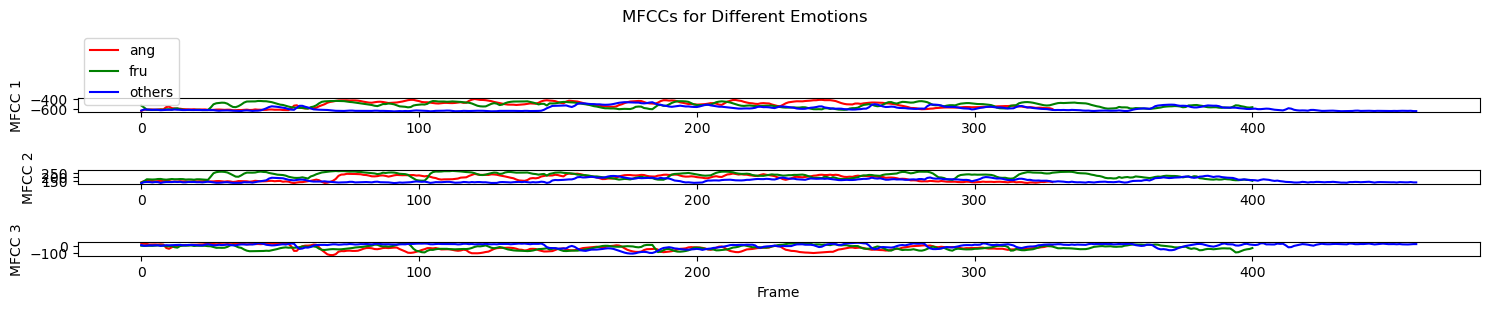

In [45]:
MFCCS = 13


# Extract MFCCs
y1_mfcc = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=MFCCS)
y2_mfcc = librosa.feature.mfcc(y=y2, sr=sr, n_mfcc=MFCCS)
y3_mfcc = librosa.feature.mfcc(y=y3, sr=sr, n_mfcc=MFCCS)

# Plot the MFCCs
plt.figure(figsize=(15, 10))

# Plot each MFCC coefficient separately for clarity
for i in range(3):
    plt.subplot(MFCCS, 1, i+1)
    plt.plot(y1_mfcc[i], color='r', label=sampled_emotion_list[INT] if i == 0 else "")
    plt.plot(y2_mfcc[i], color='g', label=sampled_emotion_list[INT_] if i == 0 else "")
    plt.plot(y3_mfcc[i], color='b', label=sampled_emotion_list[INT__] if i == 0 else "")
    plt.ylabel(f'MFCC {i+1}')
    if i == 0:
        plt.legend()

plt.xlabel('Frame')
plt.suptitle('MFCCs for Different Emotions')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

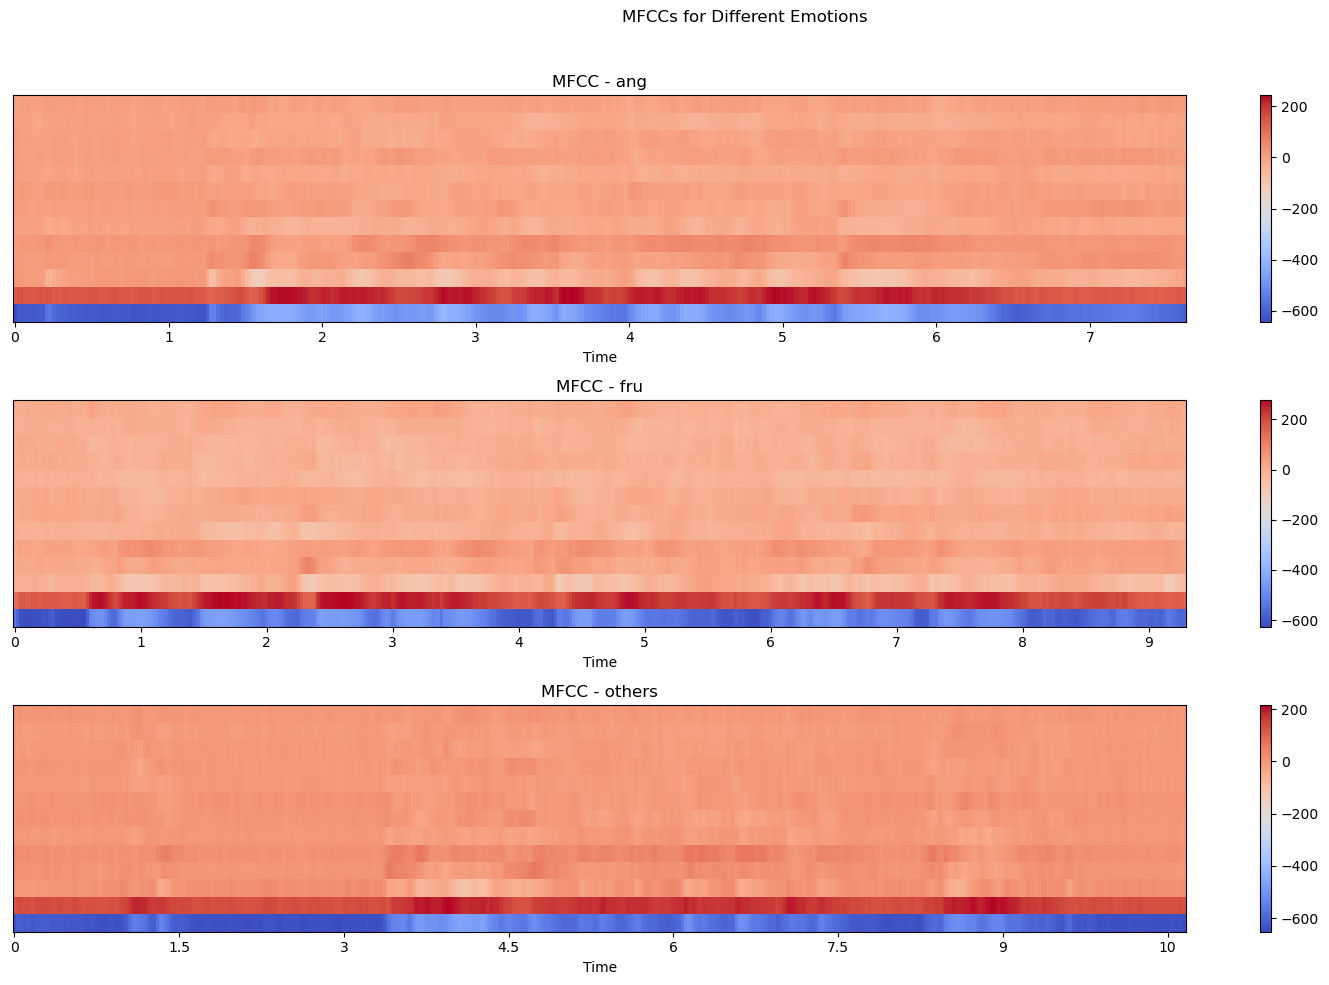

In [51]:
y1_mfcc = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=MFCCS)
y2_mfcc = librosa.feature.mfcc(y=y2, sr=sr, n_mfcc=MFCCS)
y3_mfcc = librosa.feature.mfcc(y=y3, sr=sr, n_mfcc=MFCCS)

# Plot the MFCCs as heatmaps
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Function to plot MFCC heatmap
def plot_mfcc_heatmap(mfcc, ax, title):
    img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    ax.set(title=title)

plot_mfcc_heatmap(y1_mfcc, axes[0], f'MFCC - {sampled_emotion_list[INT]}')
plot_mfcc_heatmap(y2_mfcc, axes[1], f'MFCC - {sampled_emotion_list[INT_]}')
plot_mfcc_heatmap(y3_mfcc, axes[2], f'MFCC - {sampled_emotion_list[INT__]}')

plt.suptitle('MFCCs for Different Emotions')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Text(0, 0.5, 'Autocorrelations')

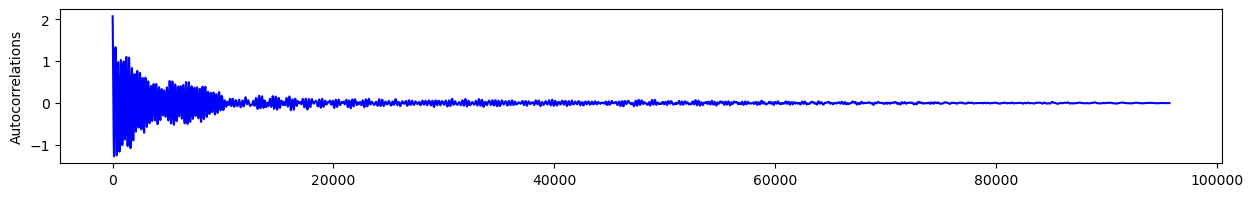

In [20]:
autocorr1 = librosa.core.autocorrelate(y1)
autocorr2 = librosa.core.autocorrelate(y2)
plt.figure(figsize=(15,2))
plt.plot(autocorr2, color='b')
plt.ylabel('Autocorrelations')

Text(0, 0.5, 'Center-clipped Autocorrelation')

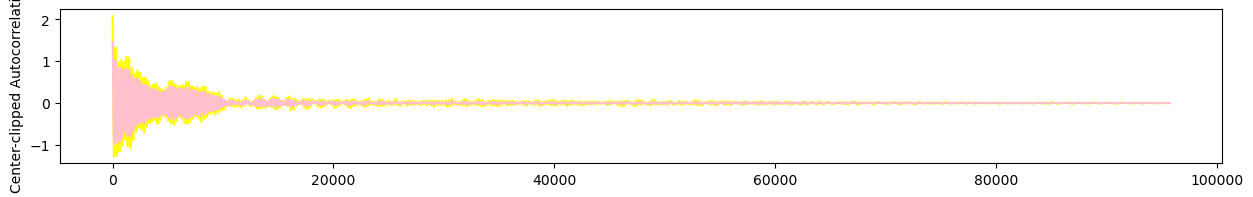

In [22]:
cl = 0.45 * np.mean(abs(y2))
center_clipped = []
for s in y2:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
plt.figure(figsize=(15,2))
plt.plot(autocorr2, color='yellow')
plt.plot(new_autocorr, color='pink')
plt.ylabel('Center-clipped Autocorrelation')

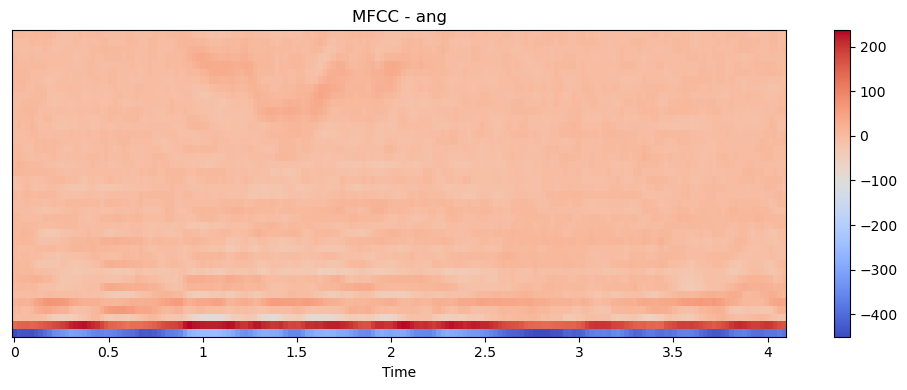

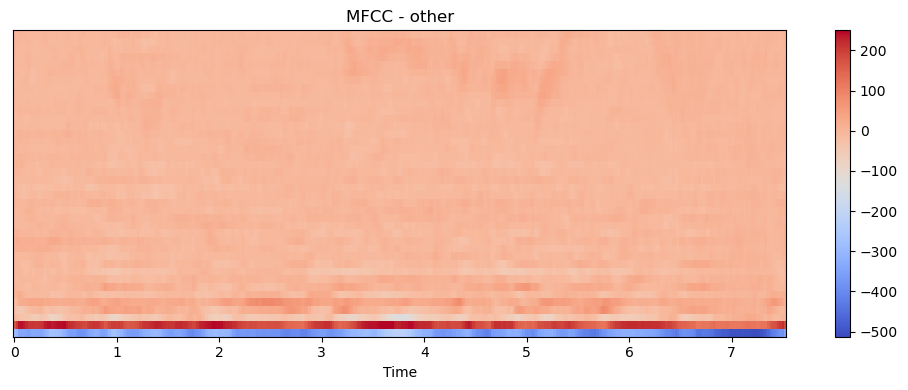

In [65]:
# Example assuming you have real audio files
import os
def plot_mfcc(mfcc, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC - {emotion}')
    plt.tight_layout()
    plt.show()
    
    
audio_files = {
    'ang': y1,
    'other': y2
}

# Function to extract and plot MFCCs for real audio files
def extract_and_plot_mfcc_real(y, emotion):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plot_mfcc(mfcc, emotion)

# Plot MFCCs for real audio files
for emotion, file_path in audio_files.items():
    extract_and_plot_mfcc_real(file_path, emotion)


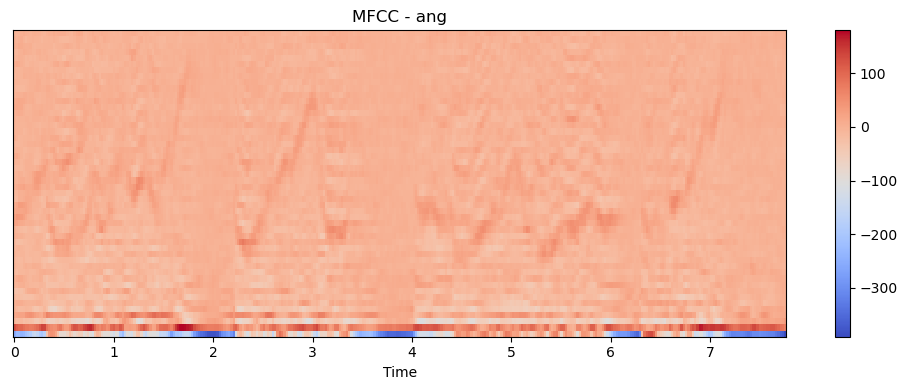

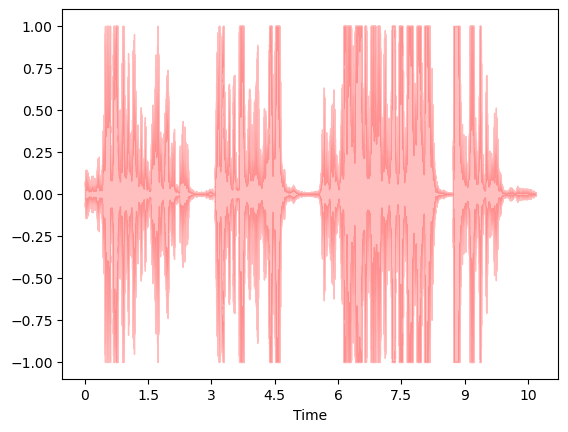

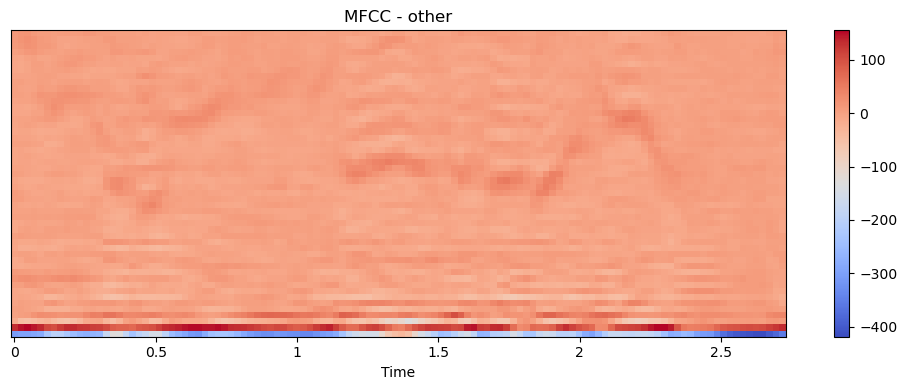

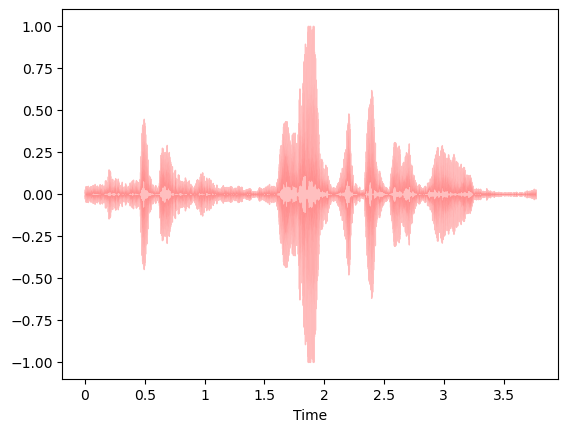

In [83]:
# Example assuming you have real audio files
import os

audio_files = {
    'ang': '/Users/sensenc/Downloads/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F022.wav',
    'other': '/Users/sensenc/Downloads/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F002.wav'
}

# Function to extract and plot MFCCs for real audio files
def extract_and_plot_mfcc_real(file_path, emotion):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    plot_mfcc(mfcc, emotion)
    
def extract_and_plot_wave_real(file_path):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure()
    librosa.display.waveshow(y=y, sr=sr,alpha=0.25, color='r')
    # plot_mfcc(mfcc, emotion)
    
# librosa.display.waveshow(y1, sr=sr, alpha=0.25, color='r')


# Plot MFCCs for real audio files
for emotion, file_path in audio_files.items():
    extract_and_plot_mfcc_real(file_path, emotion)
    extract_and_plot_wave_real(file_path)
